In [15]:
import time
import torch
import matplotlib.pyplot as plt

from ase import Atoms
from batch_nl import NeighbourList

from vesin import ase_neighbor_list as vesin_ase_neighbor_list
from matscipy.neighbours import neighbour_list as matscipy_neighbour_list
from torch_nl import compute_neighborlist, ase2data
from nvalchemiops.neighborlist import neighbor_list, estimate_max_neighbors


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'lines.markersize': 4,
    'lines.linewidth': 1.5,  # Increased from 1 to 1.5
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
})

colors = sns.color_palette("deep")

In [32]:
def time_fn(fn, n_tries=10, sync_cuda=False):
    """
    A simple function to time a function.
    """

    # warmup run

    fn()
    fn()
    fn()

    times = []

    for _ in range(n_tries):

        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()
        
        start = time.perf_counter()

        fn()

        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()

        end = time.perf_counter()

        times.append((end - start) * 1000.0)  # ms

    if n_tries == 1:
        return times[0], 0.0

    mean_ms = sum(times) / n_tries

    # sample variance (no math)
    var = sum((t - mean_ms)**2 for t in times) / (n_tries - 1)

    # std and stderr via **0.5 instead of math.sqrt
    std_ms = var ** 0.5
    stderr_ms = std_ms / ((n_tries) ** 0.5)

    return mean_ms, stderr_ms

In [33]:
cell = [
    [2.460394, 0.0, 0.0],
    [-1.26336, 2.044166, 0.0],
    [-0.139209, -0.407369, 6.809714],
]

positions = [
    [-0.03480225, -0.10184225, 1.70242850],
    [-0.10440675, -0.30552675, 5.10728550],
    [-0.05691216,  1.26093576, 1.70242850],
    [ 1.11473716,  0.37586124, 5.10728550],
]

base = Atoms(
    symbols="CCCC",
    positions=positions,
    cell=cell,
    pbc=True,
) * (4,4,2)

print (f"density = {base.get_masses().sum() / base.get_volume()}")

density = 1.402779679354249


In [34]:

number_of_structures = [1, 2, 4, 8, 16, 32, 64, 128]     
radii = [3.0, 4.5, 6.0]
n_tries = 4

device = "cuda:0" 

In [35]:
results = {}   # radius → n_struct → timings dict
base_natoms = len(base)

compile_variants = [
    (torch.float64, "batch_nl_on2_f64"),
    (torch.float32, "batch_nl_on2_f32"),
]

for radius in radii:
    print("\n" + "=" * 80)
    print(f"radius = {radius}")
    print("=" * 80)

    results[radius] = {}

    for n_struct in number_of_structures:
        configs = [base.copy() for _ in range(n_struct)]
        print(f"\nNumber of structures: {n_struct}  →  total_atoms = {n_struct * base_natoms}")

        res_r_n = results[radius][n_struct] = {}

        # batch_nl O(N^2) no-compile (f64)
        nl = NeighbourList(
            list_of_positions=[s.positions for s in configs],
            list_of_cells=[s.cell.array for s in configs],
            cutoff=radius,
            float_dtype=torch.float64,
            device=device,
        )
        nl.load_data()

        t, e = time_fn(lambda: nl.calculate_neighbourlist(use_torch_compile=False),
                       n_tries=n_tries, sync_cuda=True)
        res_r_n["batch_nl_on2_no_compile_f64"] = {"mean": t, "stderr": e}

        # batch_nl O(N^2) compile (f64, f32)
        for float_dtype, key in compile_variants:
            nl_comp = NeighbourList(
                list_of_positions=[s.positions for s in configs],
                list_of_cells=[s.cell.array for s in configs],
                cutoff=radius,
                float_dtype=float_dtype,
                device=device,
            )
            nl_comp.load_data()

            t, e = time_fn(lambda: nl_comp.calculate_neighbourlist(use_torch_compile=True),
                           n_tries=n_tries, sync_cuda=True)
            res_r_n[key] = {"mean": t, "stderr": e}

        # VESIN O(N)
        t, e = time_fn(
            lambda: [vesin_ase_neighbor_list("ijSDd", atoms, cutoff=radius) for atoms in configs],
            n_tries=n_tries,
            sync_cuda=False,
        )
        res_r_n["vesin_on1"] = {"mean": t, "stderr": e}

        # matscipy O(N)
        t, e = time_fn(
            lambda: [matscipy_neighbour_list("ijSDd", atoms, cutoff=radius) for atoms in configs],
            n_tries=n_tries,
            sync_cuda=False,
        )
        res_r_n["matscipy_on1"] = {"mean": t, "stderr": e}

        # shared batched data for torch-nl and NVIDIA
        pos, cell_t, pbc, batch_idx, _ = ase2data(configs, device=device)
        
        pos = pos.to(dtype=torch.float32)
        cell_t = cell_t.contiguous().view(-1, 3, 3).to(dtype=torch.float32)
        pbc = pbc.to(dtype=torch.bool)
        batch_idx = batch_idx.to(dtype=torch.int64)

        # torch-nl O(N)
        t, e = time_fn(
            lambda: compute_neighborlist(radius, pos, cell_t, pbc, batch_idx, False),
            n_tries=n_tries,
            sync_cuda=True,
        )
        res_r_n["torch_on1"] = {"mean": t, "stderr": e}

        # NVIDIA ALCHEMI O(N^2)
        t, e = time_fn(
            lambda: neighbor_list(
                pos,
                radius,
                cell=cell_t.contiguous().view(-1, 3, 3),
                pbc=pbc,
                batch_idx=batch_idx,
                method="batch_naive",
                max_neighbors=estimate_max_neighbors(radius, 0.2, 2.0),
            ),
            n_tries=n_tries,
            sync_cuda=True,
        )
        res_r_n["nvidia_on1"] = {"mean": t, "stderr": e}

        # summary
        print(
            f"  batch_nl O(N^2) no-compile (f64)   : "
            f"{res_r_n['batch_nl_on2_no_compile_f64']['mean']:8.3f} ± "
            f"{res_r_n['batch_nl_on2_no_compile_f64']['stderr']:5.3f} ms"
        )

        for _, key in compile_variants:
            pretty = "f64" if key.endswith("f64") else "f32"
            t = res_r_n[key]["mean"]
            e = res_r_n[key]["stderr"]
            print(
                f"  batch_nl O(N^2) compile ({pretty})   : "
                f"{t:8.3f} ± {e:5.3f} ms"
            )

        print(
            f"  VESIN O(N)                        : "
            f"{res_r_n['vesin_on1']['mean']:8.3f} ± {res_r_n['vesin_on1']['stderr']:5.3f} ms"
        )
        print(
            f"  matscipy O(N)                     : "
            f"{res_r_n['matscipy_on1']['mean']:8.3f} ± {res_r_n['matscipy_on1']['stderr']:5.3f} ms"
        )
        print(
            f"  torch-nl O(N)                     : "
            f"{res_r_n['torch_on1']['mean']:8.3f} ± {res_r_n['torch_on1']['stderr']:5.3f} ms"
        )
        print(
            f"  NVIDIA O(N) (batch_naive)         : "
            f"{res_r_n['nvidia_on1']['mean']:8.3f} ± {res_r_n['nvidia_on1']['stderr']:5.3f} ms"
        )



radius = 3.0

Number of structures: 1  →  total_atoms = 128
  batch_nl O(N^2) no-compile (f64)   :    1.006 ± 0.016 ms
  batch_nl O(N^2) compile (f64)   :    1.317 ± 0.020 ms
  batch_nl O(N^2) compile (f32)   :    1.104 ± 0.018 ms
  VESIN O(N)                        :    1.005 ± 0.281 ms
  matscipy O(N)                     :    0.444 ± 0.002 ms
  torch-nl O(N)                     :    4.134 ± 0.012 ms
  NVIDIA O(N) (batch_naive)         :    0.879 ± 0.008 ms

Number of structures: 2  →  total_atoms = 256
  batch_nl O(N^2) no-compile (f64)   :    1.050 ± 0.009 ms
  batch_nl O(N^2) compile (f64)   :    1.092 ± 0.014 ms
  batch_nl O(N^2) compile (f32)   :    1.055 ± 0.006 ms
  VESIN O(N)                        :    0.607 ± 0.084 ms
  matscipy O(N)                     :    0.834 ± 0.006 ms
  torch-nl O(N)                     :    7.572 ± 0.086 ms
  NVIDIA O(N) (batch_naive)         :    1.801 ± 0.551 ms

Number of structures: 4  →  total_atoms = 512
  batch_nl O(N^2) no-compile (f64)   : 

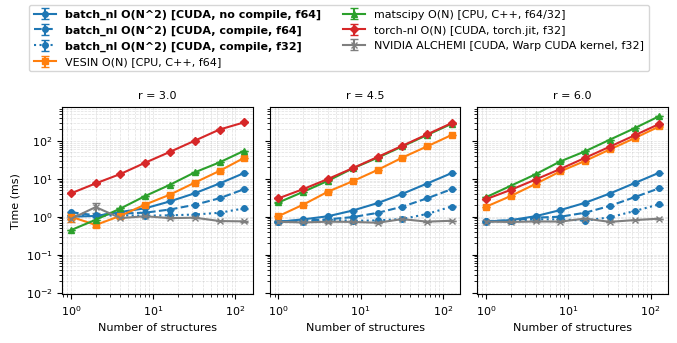

In [36]:
methods = [
    "batch_nl_on2_no_compile_f64",
    "batch_nl_on2_f64",
    "batch_nl_on2_f32",
    "vesin_on1",
    "matscipy_on1",
    "torch_on1",
    "nvidia_on1",
]

labels = {
    "batch_nl_on2_no_compile_f64": "batch_nl O(N^2) [CUDA, no compile, f64]",
    "batch_nl_on2_f64":            "batch_nl O(N^2) [CUDA, compile, f64]",
    "batch_nl_on2_f32":            "batch_nl O(N^2) [CUDA, compile, f32]",
    "vesin_on1":                   "VESIN O(N) [CPU, C++, f64]",
    "matscipy_on1":                "matscipy O(N) [CPU, C++, f64/32]",
    "torch_on1":                   "torch-nl O(N) [CUDA, torch.jit, f32]",
    "nvidia_on1":                  "NVIDIA ALCHEMI [CUDA, Warp CUDA kernel, f32]",
}

# Explicit style per method
styles = {
    # batch_nl variants (same color, different linestyles)
    "batch_nl_on2_no_compile_f64": dict(color="tab:blue", marker="o", linestyle="-"),
    "batch_nl_on2_f64":            dict(color="tab:blue", marker="o", linestyle="--"),
    "batch_nl_on2_f32":            dict(color="tab:blue", marker="o", linestyle=":"),
    # others
    "vesin_on1":                   dict(color="tab:orange", marker="s", linestyle="-"),
    "matscipy_on1":                dict(color="tab:green",  marker="^", linestyle="-"),
    "torch_on1":                   dict(color="tab:red",    marker="D", linestyle="-"),
    "nvidia_on1":                  dict(color="tab:grey",   marker="x", linestyle="-"),
}

radii_list = list(results.keys())
num_panels = len(radii_list)

fig, axes = plt.subplots(
    1,
    num_panels,
    sharex=True,
    sharey=True,
    figsize=(3.41 * 2, 3.41),
)

if num_panels == 1:
    axes = [axes]

for ax, radius in zip(axes, radii_list):

    # x-axis = number of structures
    n_struct_list = sorted(results[radius].keys())

    for method in methods:
        means  = [results[radius][n][method]["mean"]   for n in n_struct_list]
        errors = [results[radius][n][method]["stderr"] for n in n_struct_list]

        style = styles[method]

        ax.errorbar(
            n_struct_list,
            means,
            yerr=errors,
            capsize=3,
            label=labels[method],
            **style,
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"r = {radius}")
    ax.grid(True, which="both", ls="--", alpha=0.4)

for ax in axes:
    ax.set_xlabel("Number of structures")
axes[0].set_ylabel("Time (ms)")


handles, legend_labels = axes[0].get_legend_handles_labels()

leg = fig.legend(
    handles,
    legend_labels,
    loc="upper center",
    ncol=2,
)

# Make only some entries bold, e.g. those containing "batch_nl"
for text in leg.get_texts():
    label = text.get_text()
    if "batch_nl" in label:
        text.set_fontweight("bold")

plt.tight_layout(rect=[0, 0, 1, 0.78])

plt.show()